Get CAM Surface Obspack Data

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from glob import glob
import dask
import yaml
import os
import cftime
import datetime as dt
import numpy as np
import xarray as xr
import re
import matplotlib.pyplot as plt
import util
import cesm_tools
from matplotlib.lines import Line2D

Generate Cluster for parallel computing

In [3]:
cluster, client = util.get_ClusterClient()
cluster.scale(24)
cluster

/glade/u/home/jvance/.conda/envs/scargo/lib/python3.7/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 32891 instead
  f"Port {expected} is already in use.\n"


Set case 

In [5]:
case = 'cam6327_sd.apo-forward.001'

Get case info, pathways and generate list of data files to process

In [6]:
with open(f"caseinfo/{case}.yml") as fid:
    caseinfo = yaml.safe_load(fid)
    
srf_emis_files = caseinfo['srf_emis_files']    
archive_root = caseinfo['archive_root']    
archive_root #path to the data files for the case

file_list = sorted(glob(f"{archive_root}/atm/hist/*.cam.h1.*.nc"))
len(file_list) # number of data files to process

12419

Look into case info and get correction factor for modelled data

In [7]:
with xr.open_dataset(caseinfo['ncdata']) as ds:
    background_ppm = ds.attrs['cam_i_add_uniform_fields_background_ppm']
background_ppm #background correction factor

400.0

Generate list of atmospheric tracers for ocean surface emissions

In [8]:
tracer_list = list(srf_emis_files.keys())    
tracer_list # tracers

['apo_jena',
 'co2_cesm',
 'co2_gridfed',
 'co2_oco2mip',
 'co2_somffn',
 'n2_cesm',
 'n2_era',
 'o2_cesm',
 'o2_gk01r16',
 'o2_gridfed']

Look into case info and generate a dictionary of station locations

In [9]:
fincl_specifer = caseinfo['fincl2lonlat_dict']
fincl_specifer

{'alt': '62.507w_82.451n',
 'brw': '156.611w_71.323n',
 'cba': '162.720w_55.210n',
 'cgo': '144.690e_40.683s',
 'gould_57S': '64.222w_57.023s',
 'gould_59S': '63.317w_59.026s',
 'gould_61S': '60.621w_61.042s',
 'gould_63S': '61.123w_63.077s',
 'gould_65S': '63.855w_64.785s',
 'kum': '154.888w_19.561n',
 'ljo': '117.257w_32.867n',
 'mlo': '155.576w_19.536n',
 'psa': '64.053w_64.774s',
 'smo': '170.564w_14.247s',
 'spo': '24.800w_89.980s'}

Set a specified cache directory for processed data files

In [10]:
#cache_dir = f'{archive_root}/atm/proc/stations'
cache_dir = f'/glade/u/home/jvance/archive/data/proc/stations/'

datestr_start = file_list[0].split('.')[-2]
datestr_end = file_list[-1].split('.')[-2]

Define a function: procssess_cam_h1 
This function first applies  cesm_tools.fincl_lonlat_to_dataset to convert the spatial dimensions to a more usable format, then applies correction factor for the initial background concentration to convert the units for each atmospheric grace gas.

In [11]:
def preprocess_cam_h1(ds):
    # reformat to record dimension
    ds = cesm_tools.fincl_lonlat_to_dataset(
        ds, specifer_dict=fincl_specifer, isel_dict={"lev": -1}
    )
    # convert units
    for v in ds.data_vars:
        if v in srf_emis_files:
            ds[v] = cesm_tools.tracegas_convert_units(
                ds[v], srf_emis_files[v]["constituent"], background_ppm=background_ppm
            )
    return ds

Generate a list of years for the modelled data by reading the list of data files with names that contains the dates for each dataset within the file. 

In [12]:
year_list = [int(f.split('.')[-2].split('-')[0]) for f in file_list]
years = np.unique(year_list)
years

array([1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996,
       1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007,
       2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018,
       2019, 2020])

Define a function: process_one_file
This function applies "process_cam_h1" to the data in the specified file from and writes out the processed data to a new netcdf file.

In [10]:
@dask.delayed
def process_one_file(f, file_out):
    dsi = preprocess_cam_h1(xr.open_dataset(f))
    dsi.to_netcdf(file_out)
    return file_out

Process daily data files and aggregate into yearly files. Then write out a new processed yearly netcdf file. 

In [14]:
dirout = f"{os.environ['TMPDIR']}/tmp"
os.makedirs(dirout, exist_ok=True)

for y in years:
    filebatch = sorted(glob(f"{archive_root}/atm/hist/*.cam.h1.{y}*.nc"))
    file_list_new = []
    for f in filebatch:
        file_out = f"{dirout}/{os.path.basename(f)}"
        file_list_new.append(process_one_file(f, file_out))

    cache_file = f'{cache_dir}{case}.cam.h1.processed.{y}.nc'
    if os.path.exists(cache_file):
        continue
    else:
        file_list_new = dask.compute(*file_list_new)
        ds = xr.open_mfdataset(file_list_new, compat='override', coords='minimal')
        ds.to_netcdf(cache_file)
        ds.close()

Once the yearly processed files are writen to the directory, open them all into one dataset. 

In [13]:
processed_files = sorted(glob(f'{cache_dir}{case}.cam.h1.processed.*.nc'))

ds = xr.open_mfdataset(
        processed_files,
        parallel=True,
    ).compute()

KeyboardInterrupt: 

Specify the pathway to the Obspack data and generate a list of stations keys and a dictionaries linking the the station keys to individual station files. 

In [12]:
#Set Obspack Dirctory 
obspack_dir = "/glade/work/mclong/sno-analysis/obspack_co2_1_GLOBALVIEWplus_v7.0_2021-08-18/data/nc"
stn_keys = ["alt", "brw", "cba", "cgo", "kum", "ljo", "mlo", "psa", "smo", "spo", "gould"]

surface_files = {
    'alt': f"{obspack_dir}/co2_alt_surface-flask_4_representative.nc",
    'brw': f"{obspack_dir}/co2_brw_surface-flask_4_representative.nc",
    'cba': f"{obspack_dir}/co2_cba_surface-flask_4_representative.nc",
    'cgo': f"{obspack_dir}/co2_cgo_surface-flask_4_representative.nc",
    'kum': f"{obspack_dir}/co2_kum_surface-flask_4_representative.nc",
    'ljo': f"{obspack_dir}/co2_ljo_surface-flask_4_representative.nc",
    'mlo': f"{obspack_dir}/co2_mlo_surface-flask_4_representative.nc",
    'psa': f"{obspack_dir}/co2_psa_surface-flask_4_representative.nc",
    'smo': f"{obspack_dir}/co2_smo_surface-flask_4_representative.nc",
    'spo': f"{obspack_dir}/co2_spo_surface-flask_4_representative.nc",
    'gould': f"{obspack_dir}/co2_gould_shipboard-insitu_1_allvalid.nc",
}
    

Choose the stations to extract from the CAM model data. Then this block reads in the obspack data and interpolates the model data in time to add the modelled tracers to the obspack dataset for each station.

In [14]:
stn_keys = ["alt", "brw", "cba", "cgo", "kum", "ljo", "mlo", "psa", "smo", "spo", "gould"]

obspacks = {}
for stn in stn_keys:
    with xr.open_dataset(surface_files[stn]) as dsi:
        
        if stn == 'gould':
            gould_lat_bin_e = np.arange(-66, -54, 2)
            gould_lat_bin_c = np.vstack((gould_lat_bin_e[:-1], gould_lat_bin_e[1:])).mean(axis=0)
            groups = dsi.groupby_bins(dsi.latitude, gould_lat_bin_e).groups
            gould_dict = {
                '(-58.0, -56.0]' : 'gould_57S' ,
               '(-60.0, -58.0]':'gould_59S',
               '(-62.0, -60.0]' : 'gould_61S',
                '(-64.0, -62.0]' :'gould_63S',
                '(-66.0, -64.0]' :'gould_65S',}
            for v in tracer_list: # set up empty tracer variables 
                dsi[v] = xr.zeros_like(dsi['value'])

            for key, ndx in groups.items():
                gould_stn = gould_dict[str(key)]
                da = ds.sel(record=gould_stn).interp(time=dsi.time[ndx])
                for v in tracer_list:
                    dsi[v][ndx] = da[v]                     

            obspacks[stn] = dsi

        else:
            da = ds.sel(record=stn).interp(time=dsi.time)
            dsi = dsi.drop_vars('time')
            dsi[tracer_list] = da[tracer_list]                     
            obspacks[stn] = dsi



Choose stations and write out Obspack datasets with CAM tracers to new netcdf files. 

In [ ]:
stn_keys = ["alt", "brw", "cba", "cgo", "kum", "ljo", "mlo", "psa", "smo", "spo", 'gould']
for stn in stn_keys:
    obspacks[stn].to_netcdf(f'{cache_dir}{case}.cam_obspack.{stn}.nc')


Plot the CAM atmospheric tracers from selected stations. 

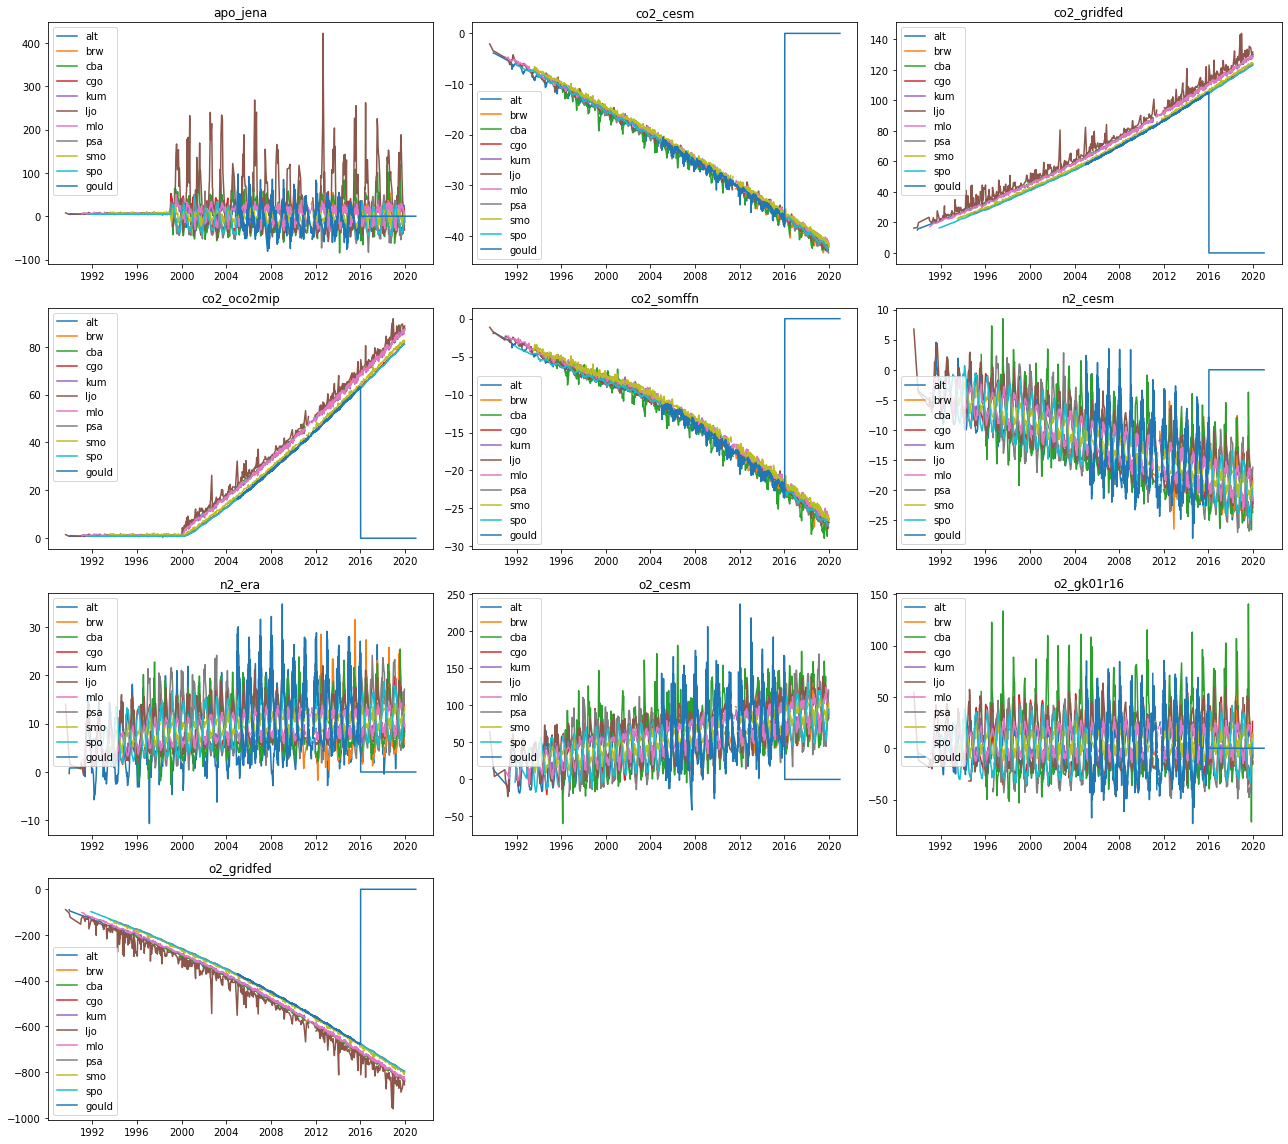

In [22]:
n = len(tracer_list)
ncol = int(np.sqrt(n))
nrow = int(((n / ncol) + n % ncol))

fig, axs = plt.subplots(nrow, ncol, figsize=(ncol * 6, nrow * 4))
for n, v in enumerate(tracer_list):
    i, j = np.unravel_index(n, axs.shape)
    ax = axs[i, j]
    for stn in stn_keys: #["cba", "psa", "spo", "cgo", "mlo","ljo"]:
        ax.plot(obspacks[stn]['time'], obspacks[stn][v], label = stn)
    ax.legend()
    ax.set_title(v)

for ni in range(n+1, ncol*nrow):
    i, j = np.unravel_index(ni, axs.shape)
    axs[i, j].remove()
plt.tight_layout()
fig.savefig('CAM_Surface_Stations.jpg', dpi = 300, bbox_inches='tight')
